# Environment Set Up

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')

# Import Dataset

In [ ]:
data = pd.read_csv('hotel_bookings_data.csv')

## Glimpse of data

In [ ]:
data.shape

(119390, 29)

> The data consists of 119,390 rows, 29 columns

In [ ]:
def Describe(data):
    total = data.isnull().sum().sort_index()
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_index()
    unique = data.nunique().sort_index()

    value = []
    for i in data.columns.sort_values():
      value.append(data[i].unique())

    D = pd.DataFrame({'Unique value' : value},index=data.columns.sort_values())

    return pd.concat([data.dtypes.sort_index(), total, percent, unique, D['Unique value']], axis=1, keys=['Dtype','Missing value', 'Missing value (%)','N-Unique','Unique value']).sort_values(by='Missing value',ascending = False)

Describe(data)

,Dtype,Missing value,Missing value (%),N-Unique,Unique value
company,float64,112593,94.306893,352,"[nan, 110.0, 113.0, 270.0, 178.0, 240.0, 154.0..."
agent,float64,16340,13.686238,333,"[nan, 304.0, 240.0, 303.0, 15.0, 241.0, 8.0, 2..."
city,object,488,0.408744,177,"[Kota Denpasar, Kabupaten Bangka, Kabupaten Sl..."
children,float64,4,0.003350,5,"[0.0, 1.0, 2.0, 10.0, 3.0, nan]"
adr,float64,0,0.000000,8879,"[0.0, 75.0, 98.0, 107.0, 103.0, 82.0, 105.5, 1..."
is_canceled,int64,0,0.000000,2,"[0, 1]"
stays_in_weekend_nights,int64,0,0.000000,17,"[0, 1, 2, 4, 3, 6, 13, 8, 5, 7, 12, 9, 16, 18,..."
stays_in_weekdays_nights,int64,0,0.000000,35,"[0, 1, 2, 3, 4, 5, 10, 11, 8, 6, 7, 15, 9, 12,..."
reservation_status,object,0,0.000000,3,"[Check-Out, Canceled, No-Show]"
required_car_parking_spaces,int64,0,0.000000,5,"[0, 1, 2, 8, 3]"


> It can be seen that several columns have null/missing values, the most common being the `company` column (94%)

> There doesn't seem to be any significant issues with the data type for each column (it's appropriate)

> There is an **undefined** value in the `meal` and `distribution_channel` columns


# Data Preprocessing

## Handling Missing Value

In [ ]:
data.fillna({'company': 0, 'agent': 0, 'children': 0, 'city': 'unknown'}, inplace=True)

## Correcting Value

In [ ]:
data['meal'].value_counts()

Breakfast     92310
Dinner        14463
No Meal       10650
Undefined      1169
Full Board      798
Name: meal, dtype: int64

In [ ]:
data.replace({'meal': {'Undefined':'No Meal'}}, inplace=True)
data['meal'].value_counts()

Breakfast     92310
Dinner        14463
No Meal       11819
Full Board      798
Name: meal, dtype: int64

## Drop Unnecesary Data

In [ ]:
# Use assign to add total_guests and stay_duration columns
data = data.assign(
    guests = lambda x: x['adults'] + x['children'] + x['babies'],
    stay_durations = lambda x: x['stays_in_weekend_nights'] + x['stays_in_weekdays_nights']
)

# Print the data count with 0 guests or 0 nights
print(f'Data with 0 guest: {data[data["guests"] == 0].shape[0]} out of {data.shape[0]} all data')
print(f'Data with 0 night: {data[data["stay_durations"] == 0].shape[0]} out of {data.shape[0]} all data')

# Select the required data with the query method
data_clean = data.query('guests > 0 and stay_durations > 0')

# Print the amount of data before and after processing
print(f'before pre-processing: {data.shape[0]}')
print(f'after pre-processing: {data_clean.shape[0]}')


Data with 0 guest: 180 out of 119390 all data
Data with 0 night: 715 out of 119390 all data
before pre-processing: 119390
after pre-processing: 118565


# EDA

In [ ]:
data_clean.shape

(118565, 31)

# Monthly Booking Analysis By Hotel Type

In [ ]:
# Create aggregation data to calculate the number of hotel bookings per month based on hotel type, year and average
df1 = data_clean.groupby(['hotel', 'arrival_date_month', 'arrival_date_year'])['is_canceled'].count().reset_index().assign(
    # Added columns for number of years per hotel and month
    ammount_of_year = lambda x: x.groupby(['hotel', 'arrival_date_month'])['arrival_date_year'].transform('count'),
    # Added columns for total bookings per hotel and month
    sum_booking = lambda x: x.groupby(['hotel', 'arrival_date_month'])['is_canceled'].transform('sum'),
    # Added average booking columns per hotel and month
    avg_num_booking = lambda x: round(x['sum_booking'] / x['ammount_of_year'])
).rename(columns={'is_canceled':'total_booking'}) # Mengubah nama kolom

df1


,hotel,arrival_date_month,arrival_date_year,total_booking,ammount_of_year,sum_booking,avg_num_booking
0,City Hotel,April,2018,2347,2,4917,2458.0
1,City Hotel,April,2019,2570,2,4917,2458.0
2,City Hotel,August,2018,3914,2,7874,3937.0
3,City Hotel,August,2019,3960,2,7874,3937.0
4,City Hotel,December,2017,3368,2,7554,3777.0
5,City Hotel,December,2018,4186,2,7554,3777.0
6,City Hotel,February,2017,1637,2,4097,2048.0
7,City Hotel,February,2018,2460,2,4097,2048.0
8,City Hotel,January,2017,1225,2,4309,2154.0
9,City Hotel,January,2018,3084,2,4309,2154.0


In [ ]:
# Create a dictionary containing pairs of month names and month numbers
month_dict = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6,
              'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}

# Replacing the arrival_date_month column value with the month number using the .map() method
df1['arrival_date_month'] = df1['arrival_date_month'].map(month_dict)

# Create a pivot table without creating new variables
pd.pivot_table(data=df1,
               index=['arrival_date_month'],
               columns=['hotel'],
               values='avg_num_booking')


hotel,City Hotel,Resort Hotel
arrival_date_month,,
1,2154.0,1202.0
2,2048.0,1296.0
3,1856.0,1080.0
4,2458.0,1540.0
5,3206.0,1652.0
6,3729.0,1794.0
7,4092.0,1760.0
8,3937.0,1508.0
9,2685.0,1511.0


In [ ]:
# Selecting important columns to create a percentage column
data_vis1 = df1[['hotel', 'arrival_date_month', 'avg_num_booking']].drop_duplicates()

# Create a percentage column based on the average number of bookings per hotel type
data_vis1['percentage'] = round((data_vis1['avg_num_booking'] / data_vis1.groupby('hotel')['avg_num_booking'].transform('sum')) * 100, 2)

# Sort data by month of arrival
data_vis1.sort_values('arrival_date_month', ascending=True)

,hotel,arrival_date_month,avg_num_booking,percentage
8,City Hotel,1,2154.0,5.88
34,Resort Hotel,1,1202.0,6.58
6,City Hotel,2,2048.0,5.59
32,Resort Hotel,2,1296.0,7.09
14,City Hotel,3,1856.0,5.07
40,Resort Hotel,3,1080.0,5.91
0,City Hotel,4,2458.0,6.71
26,Resort Hotel,4,1540.0,8.43
42,Resort Hotel,5,1652.0,9.04
16,City Hotel,5,3206.0,8.76


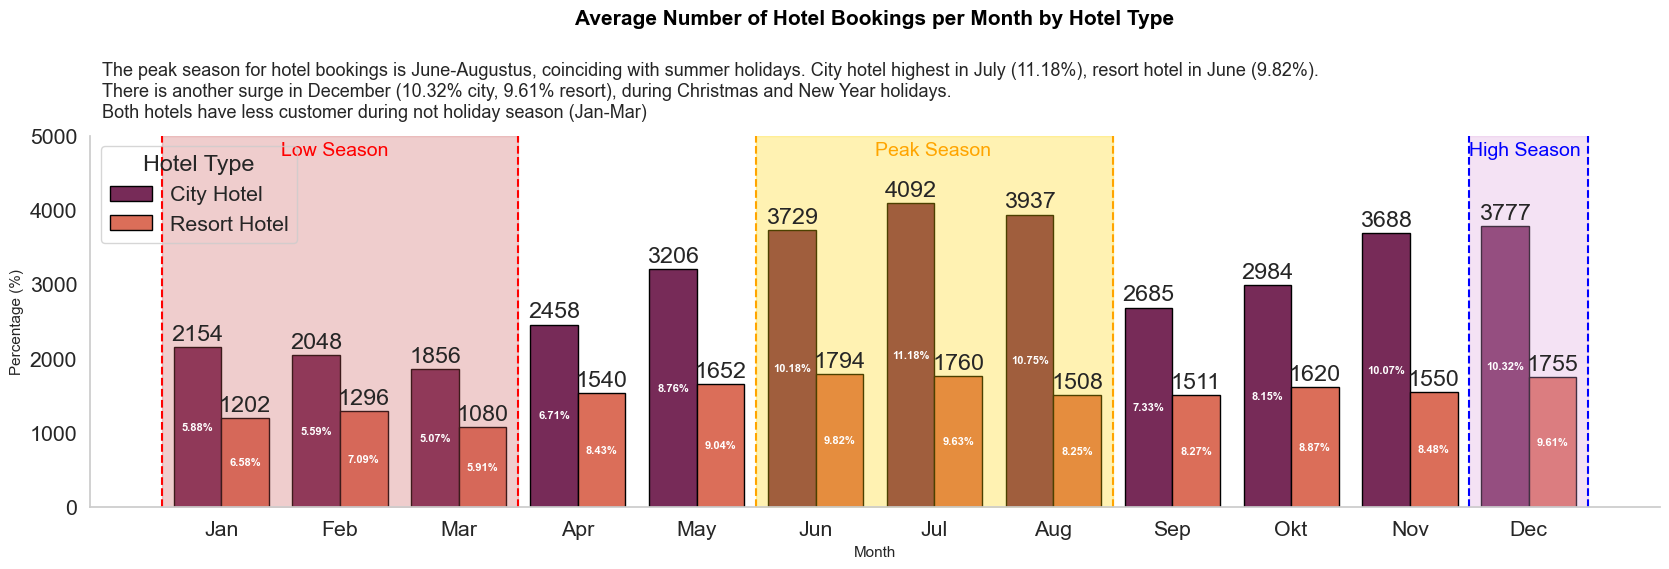

In [ ]:
# Create a bar plot with different colors for each hotel type
fig, ax = plt.subplots(figsize=(17, 6))
plt.title("Average Number of Hotel Bookings per Month by Hotel Type", fontsize=15, color='black', weight='bold', pad=80)
g = sns.barplot(x='arrival_date_month', y='avg_num_booking', data=data_vis1, hue='hotel', edgecolor='black', palette='rocket')
sns.move_legend (g,"upper left")

# Added legend
plt.legend(title='Hotel Type')

plt.xlabel('Month', fontsize=11)
plt.xticks(np.arange(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dec'])
plt.ylabel('Percentage (%)', fontsize=11)
plt.ylim(0, 5000)

# Add labels for each bar
plt.bar_label(ax.containers[0], padding=2)
plt.bar_label(ax.containers[1], padding=2)

# Delete grids
plt.grid(False)

# Mark peak seasons and holidays with dotted lines and colored areas

plt.axvline(-0.5, ls='--', color='red')
plt.axvline(2.5, ls='--', color='red')
plt.stackplot(np.arange(-0.5,3.5), [[5000]], color='indianred', alpha=0.3)
plt.text(x=0.5, y=4800, s='Low Season', fontsize=14, color='red', va='center')

plt.axvline(4.5, ls='--', color='orange')
plt.axvline(7.5, ls='--', color='orange')
plt.stackplot(np.arange(4.5,8.5), [[5000]], color='gold', alpha=0.3)
plt.text(x=5.5, y=4800, s='Peak Season', fontsize=14, color='orange', va='center')

plt.axvline(10.5, ls='--', color='blue')
plt.axvline(11.5, ls='--', color='blue')
plt.stackplot(np.arange(10.5,12.5), [[5000]], color='plum', alpha=0.3)
plt.text(x=10.5, y=4800, s='High Season', fontsize=14, color='blue', va='center')

# Create more interesting captions by using facts from data
plt.text(x=-1, y=5250,
         s="The peak season for hotel bookings is June-Augustus, coinciding with summer holidays. City hotel highest in July (11.18%), resort hotel in June (9.82%).\nThere is another surge in December (10.32% city, 9.61% resort), during Christmas and New Year holidays.\nBoth hotels have less customer during not holiday season (Jan-Mar)", fontsize=13)

plt.bar_label(ax.containers[0], ['5.88%', '5.59%', '5.07%', '6.71%', '8.76%', '10.18%', '11.18%', '10.75%', '7.33%', '8.15%', '10.07%', '10.32%'], label_type='center', color='white', weight='bold', fontsize=8)
plt.bar_label(ax.containers[1], ['6.58%', '7.09%', '5.91%', '8.43%', '9.04%', '9.82%', '9.63%', '8.25%', '8.27%', '8.87%', '8.48%', '9.61%'], label_type='center', color='white', weight='bold', fontsize=8)

# Removes plot outlines
sns.despine()
plt.tight_layout()


# Impact Analysis of Stay Duration on Hotel Bookings Cancellation Rates

<Axes: xlabel='total_nights', ylabel='Count'>

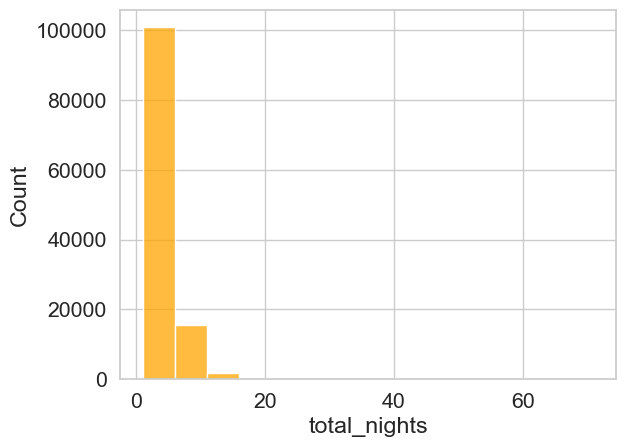

In [ ]:
df2 = data_clean.copy()

# Aggregate data to get duration of stay based on hotel type
df2["total_nights"] = df2["stays_in_weekend_nights"] + df2["stays_in_weekdays_nights"] # look up the total nights booked

sns.histplot(data=df2, x="total_nights", binwidth=5, color="orange")

In [ ]:
# Grouping data based on observations of data distribution
conditions = [
    (df2['total_nights'] > 21),
    (df2['total_nights'] > 14)
]
choices = [21, 15]
df2['total_nights_group'] = np.select(conditions, choices, df2['total_nights'])

# Create an aggregate table
data_vis2 = df2.groupby(['hotel', 'is_canceled', 'total_nights_group'])['arrival_date_month'] \
    .count().reset_index(name='num_bookings') \
    .pivot_table(index=['hotel', 'total_nights_group'], columns='is_canceled', values='num_bookings') \
    .reset_index()
data_vis2['pct_canceled'] = round(data_vis2[1] * 100.0 / (data_vis2[0] + data_vis2[1]), 2)

data_vis2.head(100)

is_canceled,hotel,total_nights_group,0,1,pct_canceled
0,City Hotel,1,9155,4103,30.95
1,City Hotel,2,10983,10432,48.71
2,City Hotel,3,11889,9482,44.37
3,City Hotel,4,7694,4853,38.68
4,City Hotel,5,3210,1775,35.61
5,City Hotel,6,1111,938,45.78
6,City Hotel,7,1245,808,39.36
7,City Hotel,8,205,176,46.19
8,City Hotel,9,119,93,43.87
9,City Hotel,10,80,116,59.18


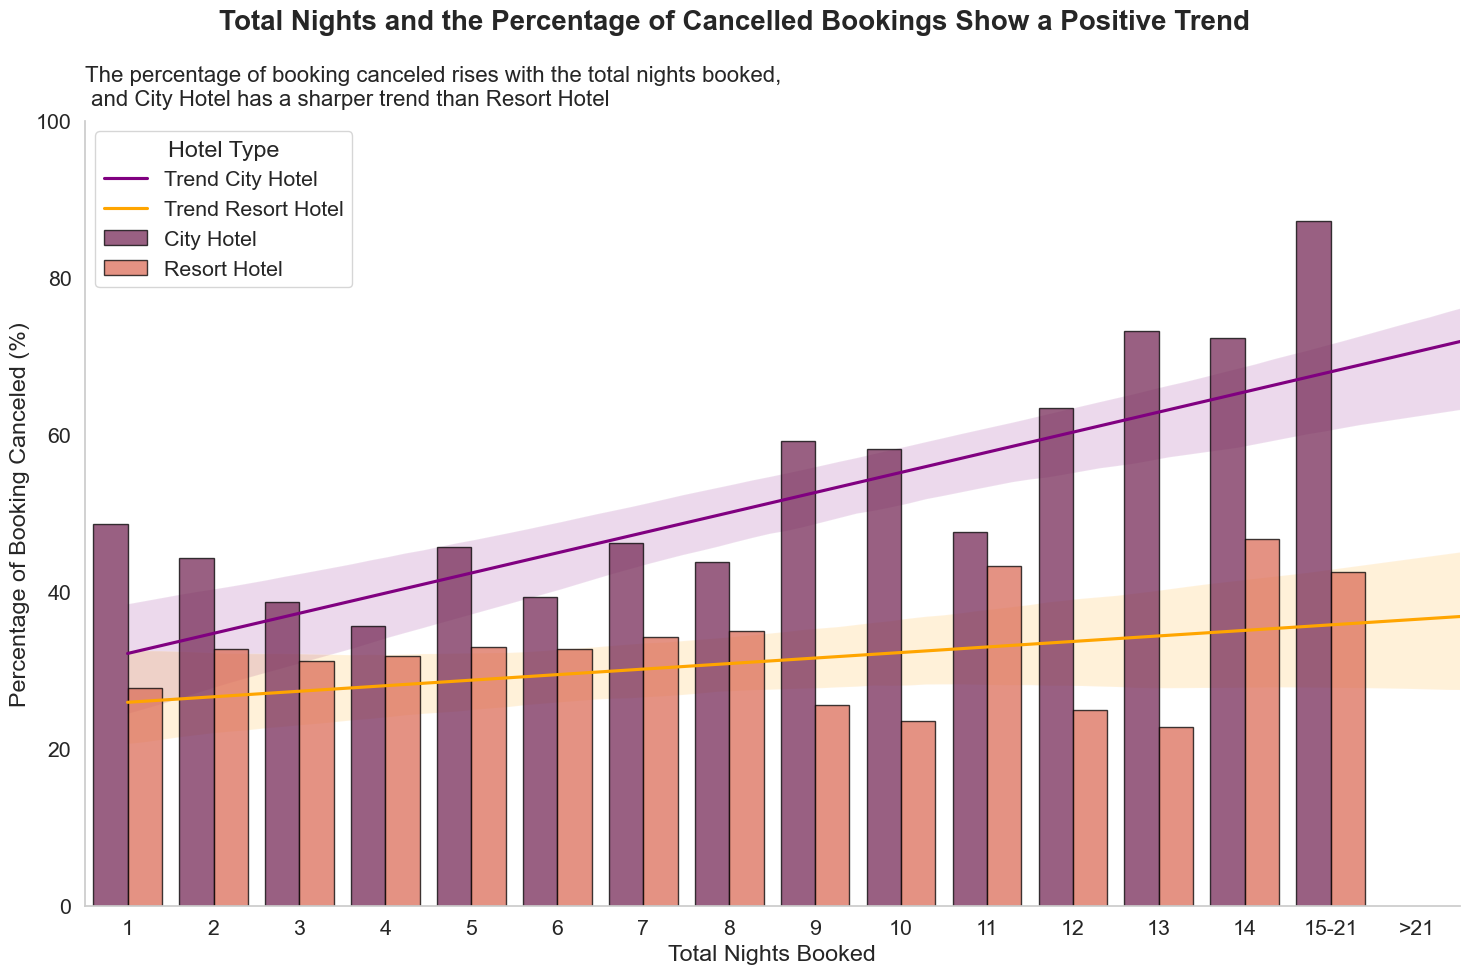

In [ ]:
# Set the plot style and size
sns.set(style='whitegrid', font_scale=1.4)

# Create plots with different colors
plt.figure(figsize=(15, 10))
plt.rcParams['axes.facecolor'] = 'none'  # Set the background to transparent
sns.regplot(x='total_nights_group', y='pct_canceled', data=data_vis2[data_vis2['hotel'] == 'City Hotel'], scatter=False, label='Trend City Hotel', color='purple')
sns.regplot(x='total_nights_group', y='pct_canceled', data=data_vis2[data_vis2['hotel'] == 'Resort Hotel'], scatter=False, label='Trend Resort Hotel', color='orange')
sns.barplot(x='total_nights_group', y='pct_canceled', hue='hotel', edgecolor='black', data=data_vis2, alpha=0.75, palette='rocket')

# Delete grids
plt.grid(False)

# Added legend
plt.legend(title='Hotel Type')

# Set labels on the x-axis and y-axis
plt.xticks(range(0, 17, 1), labels=[str(x) for x in range(0, 15, 1)] + ['15-21', '>21'])  # Set customized-label on x-axis
plt.xlabel('Total Nights Booked')  # Set the title on the x-axis
plt.ylabel('Percentage of Booking Canceled (%)')  # Set the title on the y-axis
plt.ylim(0, 100)  # Limiting the y axis
plt.xlim(0.5, 16.5)  # Limit the x axis

# Add informative titles and captions
plt.suptitle('Total Nights and the Percentage of Cancelled Bookings Show a Positive Trend', fontsize=20, fontweight='bold')
plt.text(x=0.5, y=102, s='The percentage of booking canceled rises with the total nights booked, \n and City Hotel has a sharper trend than Resort Hotel',
         fontsize=16)
sns.despine()
plt.tight_layout()
plt.show()


# Impact Analysis of Lead Time on Hotel Bookings Cancellation Rate

<Axes: xlabel='lead_time', ylabel='Count'>

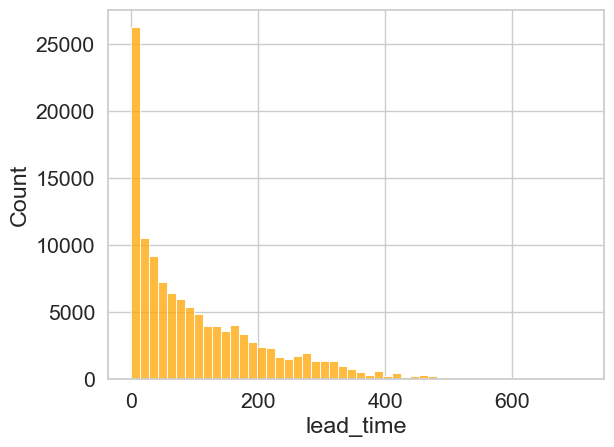

In [ ]:
df3 = data_clean.copy()

sns.histplot(data=df3, x='lead_time', bins=50, color='orange')

In [ ]:
time_range = []
for i in df3['lead_time']:
    if i <= 30:
        lead_group = '1 Month'
    elif i <= 360:
        lead_group = str(math.ceil(i / 30))+ ' Months'
    else:
        lead_group = '>12 Months'
    time_range.append(lead_group)
df3['time_range_month'] = time_range

In [ ]:
df3['time_range_month'].value_counts()

1 Month       38094
2 Months      16896
3 Months      12541
4 Months      10414
5 Months       8126
6 Months       7844
7 Months       5649
8 Months       4303
10 Months      3419
>12 Months     3412
9 Months       3400
11 Months      2754
12 Months      1713
Name: time_range_month, dtype: int64

In [ ]:
df3 = df3.groupby(['hotel', 'time_range_month', 'is_canceled'], as_index=False).agg({'agent':'count'})
df3.rename(columns={'agent':'num_booking'}, inplace=True)

df3['sum_booking'] = df3.groupby(['hotel', 'time_range_month'])['num_booking'].transform('sum')

df3['cancel_rate'] = round((df3['num_booking']/df3['sum_booking'])*100, 2)
df3


,hotel,time_range_month,is_canceled,num_booking,sum_booking,cancel_rate
0,City Hotel,1 Month,0,17848,23022,77.53
1,City Hotel,1 Month,1,5174,23022,22.47
2,City Hotel,10 Months,0,659,2518,26.17
3,City Hotel,10 Months,1,1859,2518,73.83
4,City Hotel,11 Months,0,514,2118,24.27
5,City Hotel,11 Months,1,1604,2118,75.73
6,City Hotel,12 Months,0,217,1221,17.77
7,City Hotel,12 Months,1,1004,1221,82.23
8,City Hotel,2 Months,0,7251,11858,61.15
9,City Hotel,2 Months,1,4607,11858,38.85


In [ ]:
data_vis3 = df3[df3['is_canceled']==1]
data_vis3

,hotel,time_range_month,is_canceled,num_booking,sum_booking,cancel_rate
1,City Hotel,1 Month,1,5174,23022,22.47
3,City Hotel,10 Months,1,1859,2518,73.83
5,City Hotel,11 Months,1,1604,2118,75.73
7,City Hotel,12 Months,1,1004,1221,82.23
9,City Hotel,2 Months,1,4607,11858,38.85
11,City Hotel,3 Months,1,3690,8890,41.51
13,City Hotel,4 Months,1,3486,7441,46.85
15,City Hotel,5 Months,1,2542,5603,45.37
17,City Hotel,6 Months,1,2716,5156,52.68
19,City Hotel,7 Months,1,1793,3590,49.94


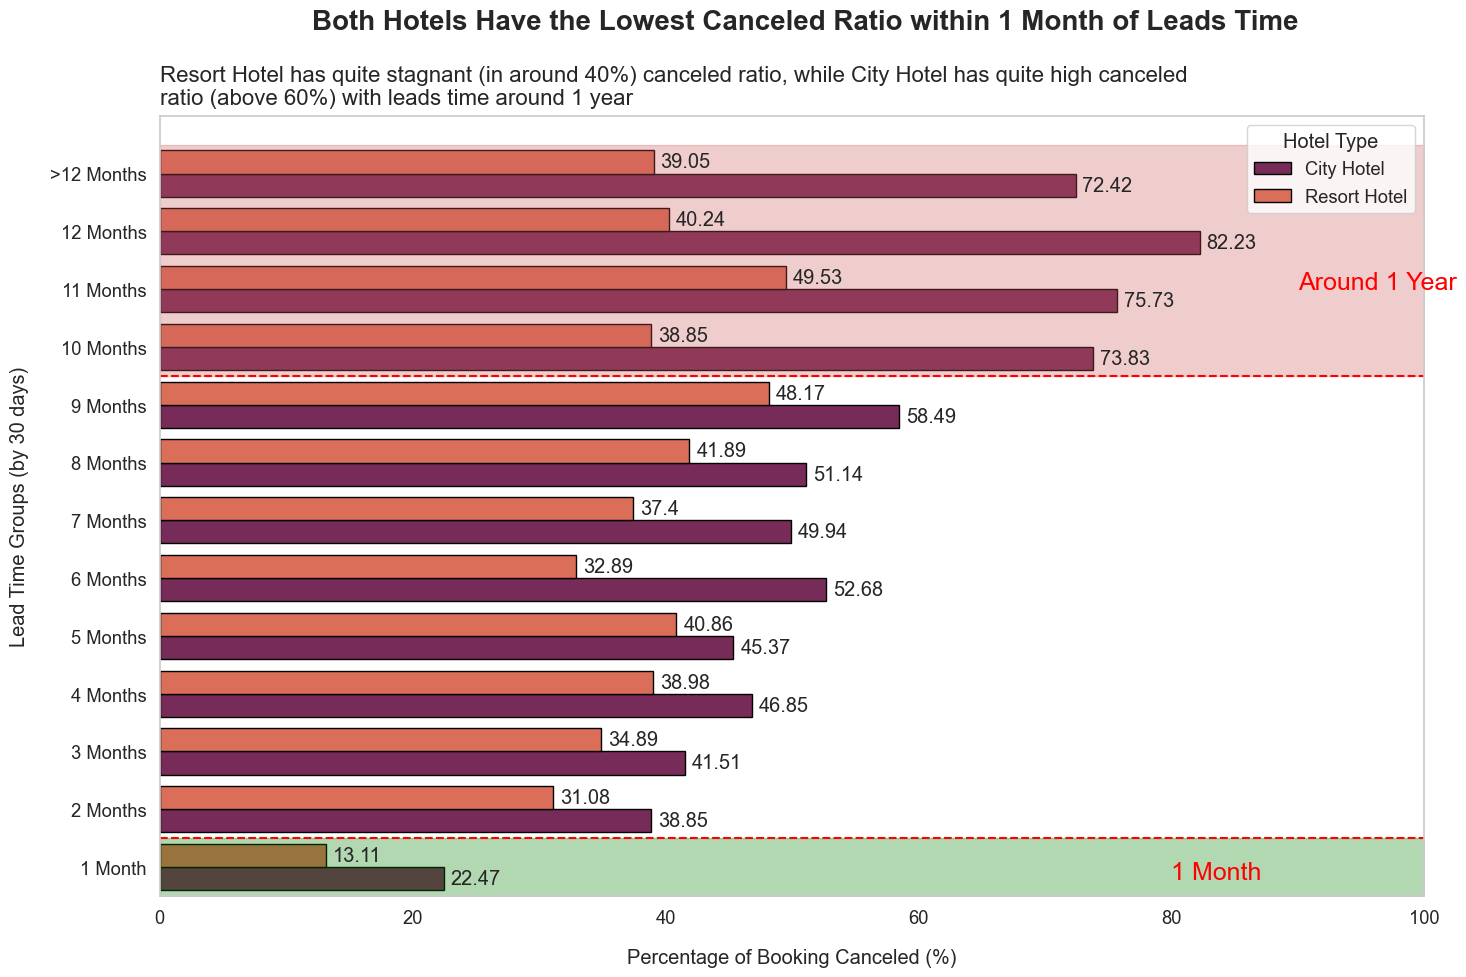

In [ ]:
# set global style
sns.set(font_scale=1.2, style='whitegrid')

# create barplot
ax = sns.barplot(x='cancel_rate', y='time_range_month', hue='hotel',
                 order=['1 Month','2 Months','3 Months','4 Months','5 Months','6 Months',
                        '7 Months','8 Months','9 Months','10 Months','11 Months',
                        '12 Months','>12 Months'],
                 hue_order=['City Hotel', 'Resort Hotel'], data=data_vis3, edgecolor = 'black', palette='rocket')

# Delete grids
plt.grid(False)

# Added legend
plt.legend(title='Hotel Type')

# set axis labels and limits
ax.set_ylabel('Lead Time Groups (by 30 days)', labelpad=15)
ax.set_xlabel('Percentage of Booking Canceled (%)', labelpad=15)
ax.set_xlim(0, 100)
ax.set_ylim(-0.5,13)

plt.bar_label(ax.containers[0], padding=5)
plt.bar_label(ax.containers[1], padding=5)

# set legend title and location
sns.move_legend (ax,'upper right')

# set figure size
ax.figure.set_size_inches(15, 10)

# add informative title and subtitle
plt.text(x=12, y=14.5, s="Both Hotels Have the Lowest Canceled Ratio within 1 Month of Leads Time",
         fontsize=20, fontweight='bold')
plt.text(x=0.0, y=13.2, s="Resort Hotel has quite stagnant (in around 40%) canceled ratio, while City Hotel has quite high canceled \nratio (above 60%) with leads time around 1 year",
         fontsize=16)

# add annotations and horizontal lines
plt.annotate('1 Month', xy=(80, -0.2), xytext=(80, -0.2), fontsize=18, color='red')
plt.axhline(0.5, ls='--', color='red')
plt.fill_between([0, 100], [-0.5, -0.5], [0.5, 0.5], color='green', alpha=0.3)
#plt.fill_between([100], [100, 100], color='indianred', alpha=1)

plt.annotate('Around 1 Year', xy=(90, 10), xytext=(90, 10), fontsize=18, color='red')
plt.axhline(8.5, ls='--', color='red')
plt.fill_between([0, 100], [8.5, 8.5], [12.5, 12.5], color='indianred', alpha=0.3)
#plt.fill_between([100], [8.5, 12.5], color='indianred', alpha=1)

# adjust layout and save figure
plt.tight_layout()
#plt.savefig('fig/investigate_hotel_business_v03.png', dpi=200);
